In [1]:
import os
os.chdir('../')
os.getcwd()

'/work'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm

In [4]:
# from transfer_methods.TrAdaBoost import TrAdaBoostClassifier

In [5]:
from process.preprocess.get_dataset import get_dataset
from process.mainprocess.models import TrAdaBoost
from process.mainprocess.run_model import return_metrics

In [48]:
import importlib
from process.mainprocess import models
importlib.reload(models)
from process.mainprocess.models import TrAdaBoost

In [6]:

def _split_data(options, df, target_domain, exp_round):

    n_target = options['experiments']['n_targets']
    n_source = options['experiments']['n_sources']
    y_feature = options['datasets']['y_feature']
    split_col =  options['datasets']['split_feature']

    # データの分割
    # targetデータはデータ数を小さくするためランダムサンプリング
    target_df = df.query("{} == '{}'".format(split_col, target_domain))\
                .sample(n=n_target, random_state=exp_round)
    target_X_train = target_df.drop(columns=y_feature).drop(columns=split_col).values
    domain_col_target = target_df[split_col].values
    target_Y_train = target_df[y_feature].values
    # サンプリングされなかったデータをtestデータとする
    target_df_test = df.query("{} == '{}'".format(split_col, target_domain))\
                     .drop(index=target_df.index)
    target_X_test = target_df_test.drop(columns=y_feature).drop(columns=split_col).values
    target_Y_test = target_df_test[y_feature].values
    
    source_df = df.query(f"{split_col} != @target_domain").sort_values(split_col)\
                    .sample(n=n_source, random_state=exp_round)
    source_X = source_df.drop(columns=y_feature).drop(columns=split_col).values
    source_Y = source_df[y_feature].values
    domain_col_source = source_df[split_col].values


    X = np.concatenate([source_X, target_X_train])
    y = np.concatenate([source_Y, target_Y_train])
    domain_col = np.concatenate([domain_col_source, domain_col_target])


    return X, y, target_X_train, target_Y_train, target_X_test, target_Y_test, domain_col

In [7]:
options = {
    "datasets": {
        "source": "uci",
        "dataset_name": "mushroom",
        "task": "classification",
        "split_feature": "stalk_shape",
        "split_feature_name": "stalk_shape",
        "y_feature": "Attributes"
    },
    "experiments": {
        "n_targets": 15,
        "n_sources": 100
    },
    "model_params":{
        "TrAdaBoost": {
            "n_estimators": 30,
            # learning_rate: 0.1
            "base_estimator": {
              "name": "DecisionTree",
              "max_depth": 3
            },
        }
    }
}

In [8]:
df = get_dataset(options["datasets"])

In [9]:
df

,Attributes,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,5.0,2.0,4.0,1.0,6.0,1.0,0.0,1.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0
1,e,5.0,2.0,9.0,1.0,0.0,1.0,0.0,0.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,1.0
2,e,0.0,2.0,8.0,1.0,3.0,1.0,0.0,0.0,5.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,3.0
3,p,5.0,3.0,8.0,1.0,6.0,1.0,0.0,1.0,5.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0
4,e,5.0,2.0,3.0,0.0,5.0,1.0,1.0,0.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,3.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,11.0,...,2.0,5.0,5.0,0.0,1.0,1.0,4.0,0.0,1.0,2.0
8120,e,5.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,11.0,...,2.0,5.0,5.0,0.0,0.0,1.0,4.0,0.0,4.0,2.0
8121,e,2.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,5.0,...,2.0,5.0,5.0,0.0,1.0,1.0,4.0,0.0,1.0,2.0
8122,p,3.0,3.0,4.0,0.0,8.0,1.0,0.0,1.0,0.0,...,1.0,7.0,7.0,0.0,2.0,1.0,0.0,7.0,4.0,2.0


In [10]:
target_domain = "e"

In [11]:
def main_experiment(options, df, target_domain, exp_num):
    X_train, y_train, X_train_target, y_train_target, \
    X_test, y_test, domain_col = _split_data(options, df, target_domain, exp_num)
    model = TrAdaBoost(options, "TrAdaBoost")
    model.fit(X_train, y_train, domain_col, target_domain)
    y_pred = model.predict(X_test)
    metric = return_metrics(y_test, y_pred, "error rate")
    
    return metric

In [14]:
def main(target_domain, df):
    n_source_all = len(df)-sum(df["stalk_shape"]==target_domain)
    n_experiments = 10
    target_range = range(10, 110, 10)
    source_range = range(100,n_source_all,100)
    idx_len = n_experiments * len(target_range) * len(source_range)

    cols = ["n_target", "n_source", "metric"]
    results = pd.DataFrame(np.empty((idx_len, 3)), columns=cols)

    bar = tqdm(total=idx_len)
    bar.set_description(f'for : target_domain={target_domain}')

    idx = 0
    for n_target in target_range:
        options["experiments"]["n_targets"] = n_target
        for n_source in source_range:
            options["experiments"]["n_sources"] = n_source
            for exp_num in range(n_experiments):
                metric = main_experiment(options, df, target_domain, exp_num)
                results.loc[idx,"n_target"] = n_target
                results.loc[idx,"n_source"] = n_source
                results.loc[idx,"metric"] = metric
                idx += 1
                bar.update(1)
                
    return results

In [15]:
results_e = main("e", df)

In [16]:
results_t = main("t", df)

In [17]:
results_e

,n_target,n_source,metric
0,10.0,100.0,0.540217
1,10.0,100.0,0.540502
2,10.0,100.0,0.539932
3,10.0,100.0,0.540217
4,10.0,100.0,0.540787
...,...,...,...
4595,100.0,4600.0,0.042740
4596,100.0,4600.0,0.541569
4597,100.0,4600.0,0.052693
4598,100.0,4600.0,0.022834


In [18]:
results_t

,n_target,n_source,metric
0,10.0,100.0,0.437364
1,10.0,100.0,0.437364
2,10.0,100.0,0.437799
3,10.0,100.0,0.437799
4,10.0,100.0,0.437799
...,...,...,...
3495,100.0,3500.0,0.437666
3496,100.0,3500.0,0.436557
3497,100.0,3500.0,0.437001
3498,100.0,3500.0,0.041482


<AxesSubplot:xlabel='n_source', ylabel='n_target'>

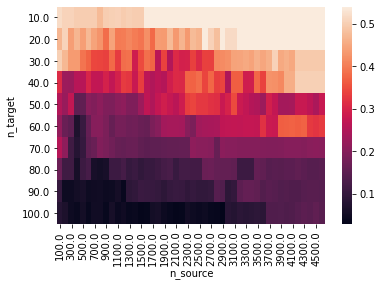

In [28]:
summary_e = results_e.groupby(["n_target","n_source"]).mean().reset_index()
wide_e = summary_e.pivot("n_target","n_source","metric")
sns.heatmap(wide_e)

<AxesSubplot:xlabel='n_source', ylabel='n_target'>

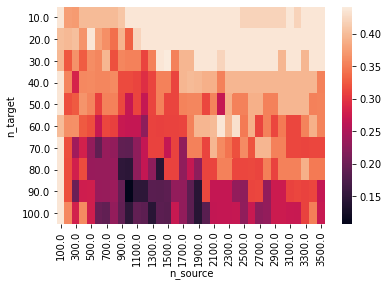

In [27]:
summary_t = results_t.groupby(["n_target","n_source"]).mean().reset_index()
wide_t = summary_t.pivot("n_target","n_source","metric")
sns.heatmap(wide_t)

# init_weightsを変更

In [39]:
X_train, y_train, X_train_target, y_train_target, \
X_test, y_test, domain_col = _split_data(options, df, target_domain, 0)
a = np.where(domain_col==target_domain, 1, 0.1)
a/=a.sum()

In [37]:
domain_col, target_domain

(array(['t', 't', 't', ..., 'e', 'e', 'e'], dtype=object), 'e')

In [75]:
def main_experiment(options, df, target_domain, exp_num):
    X_train, y_train, X_train_target, y_train_target, \
    X_test, y_test, domain_col = _split_data(options, df, target_domain, exp_num)
    weights = np.where(domain_col==target_domain, 1, 0.1)
    weights /= weights.sum() 
    model = TrAdaBoost(options, "TrAdaBoost")
    model.fit(X_train, y_train, domain_col, target_domain, weights)
    y_pred = model.predict(X_test)
    metric = return_metrics(y_test, y_pred, "error rate")
    
    return metric

In [76]:
def main(target_domain, df):
    n_source_all = len(df)-sum(df["stalk_shape"]==target_domain)
    n_experiments = 10
    idx_len = n_experiments

    cols = ["metric"]
    results = pd.DataFrame(np.empty((idx_len, 1)), columns=cols)

    bar = tqdm(total=idx_len)
    bar.set_description(f'for : target_domain={target_domain}')

    idx = 0
    options["experiments"]["n_targets"] = 25
    options["experiments"]["n_sources"] = n_source_all
    for exp_num in range(n_experiments):
        metric = main_experiment(options, df, target_domain, exp_num)
        results.loc[idx,"metric"] = metric
        idx += 1
        bar.update(1)
                
    return results

In [77]:
results_e = main("e", df)
results_e.mean()

metric    0.54059
dtype: float64

# 元のコード

In [113]:
"""
    description:
        Scikit-learn compatible implementation of the 
        TrAdaBoost algorithm from the ICML'07 paper
        "Boosting for Transfer Learning"
    author: Suraj Iyer
"""

from sklearn.base import ClassifierMixin, BaseEstimator, clone
from sklearn.svm import SVC
import numpy as np

from sklearn.utils.validation import check_X_y
from sklearn.utils.validation import check_consistent_length
from sklearn.utils.validation import check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import has_fit_parameter
from sklearn.utils.validation import _num_samples


class TrAdaBoostClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, base_estimator=SVC(), n_iters=10, domain_column='domain', verbose=False):
        assert getattr(base_estimator, 'fit', None) is not None
        assert getattr(base_estimator, 'predict', None) is not None
        assert isinstance(n_iters, int) and n_iters > 0
        assert has_fit_parameter(base_estimator, "sample_weight")

        self.base_estimator = base_estimator
        self.n_iters = n_iters
        self.verbose = verbose
        self.domain_column = domain_column

    def set_params(self, **params):
        return super(TrAdaBoostClassifier, self).set_params(**params)

    def _normalize_weights(self, weights):
        return weights/np.sum(weights)

    def _calculate_error(self, y_true, y_pred, weights):
        check_consistent_length(y_true, y_pred, weights)
        return np.sum(weights * np.abs(y_pred - y_true) / np.sum(weights))

    def fit(self, X, y=None, domain_column=None, init_weights=None):
        # initialize data
        domain_column = domain_column if domain_column else self.domain_column
        assert isinstance(domain_column, str)
        domain_column_idx = X.columns.get_loc(domain_column)
        # mask = (X[domain_column] == 1).values.T[0]
        # X.drop(domain_column, axis=1, inplace=True)
        X, y = check_X_y(X, y)

        # extract same domain and diff domain data
        mask = X[:, domain_column_idx] == 1
        X = np.delete(X, domain_column_idx, 1)  # expensive copy TODO: replace by in place drop

        # initialize weights
        n = mask.sum()
        m = _num_samples(X) - n
        n_samples = n + m
        if init_weights is None:
            init_weights = np.ones(n_samples)
        else:
            assert _num_samples(init_weights) == n_samples
        weights = init_weights
        P = np.empty((self.n_iters, n_samples))

        # initialize error vector
        error = np.empty(self.n_iters)
        beta0 = 1 / (1 + np.sqrt(2 * np.log(n / self.n_iters)))
        beta = np.empty(self.n_iters)

        # initialize estimator list for each iteration
        estimators = []

        for t in np.arange(self.n_iters):
            P[t] = self._normalize_weights(weights)

            # Call learner
            est = clone(self.base_estimator).fit(X, y, sample_weight=P[t])
            y_same_pred = est.predict(X[mask, :])

            # calculate the error on same-distribution data (X_same)
            error[t] = self._calculate_error(y[mask], y_same_pred, weights[mask])
            # error[t] = min([error[t], 0.49])  # error must be less than 0.5
            if self.verbose:
                print('Error_{}: {}'.format(t, error[t]))

            if error[t] > 0.5 or error[t] == 0:
                # if the error is 0 or > 0.5, stop updating weights
                self.n_iters = t
                beta = beta[:t]

                if self.verbose:
                    if error[t] > 0.5:
                        print("Early stopping because error: {} > 0.5".format(error[t]))
                    else:
                        print("Early stopping because error is zero.")
                break

            beta[t] = error[t] / (1 - error[t])
            if self.verbose:
                print('beta_{}: {}'.format(t, beta[t]))

            # Update the new weight vector
            if t < self.n_iters - 1:
                y_diff_pred = est.predict(X[~mask, :])
                weights[~mask] = weights[~mask] * (beta0 ** np.abs(y_diff_pred - y[~mask]))
                weights[mask] = weights[mask] * (beta[t] ** -np.abs(y_same_pred - y[mask]))

            estimators.append(est)

        if self.verbose:
            print("Number of iterations run: {}".format(self.n_iters))

        self.fitted_ = True
        self.diff_sample_weights_ = weights
        self.beta_ = beta
        self.estimators_ = estimators
        self.classes_ = getattr(estimators[0], 'classes_', None)
        self.domain_column_idx_ = domain_column_idx

        return self

    def _predict_one(self, x):
        """
        Output the hypothesis for a single instance
        :param x: array-like
            target label of a single instance from each iteration in order
        :return: 0 or 1
        """
        x, N = check_array(x, ensure_2d=False), self.n_iters
        # replace 0 by 1 to avoid zero division and remove it from the product
        beta = [self.beta_[t] if self.beta_[t] != 0 else 1 for t in range(int(np.ceil(N/2)), N)]
        # enumerate追加
        cond = np.prod([b ** -x[t] for t, b in enumerate(beta)]) >= np.prod([b ** -0.5 for b in beta])
        return int(cond)

    def predict(self, X, domain_column=None):
        check_is_fitted(self, 'fitted_')

        # remove domain column if exists
        domain_column = domain_column if domain_column else self.domain_column
        assert isinstance(domain_column, str)
        X = np.delete(X, self.domain_column_idx_, 1)  # expensive copy TODO: replace by in place drop

        y_pred_list = np.array([est.predict(X) for est in self.estimators_]).T
        # リスト化追加
        y_pred = np.array(list(map(self._predict_one, y_pred_list)))

        return y_pred

    def predict_proba(self, X):
        # TODO: have to fix how to calculate probability
        # For now, it just returns results of self.predict
        classes = self.classes_[:, np.newaxis]
        pred = (self.predict(X) == classes).T * 1
        return pred

In [114]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from process.mainprocess.models import Model

class TrAdaBoostOrigin(Model):
    def __init__(self, options, model_name):
        super().__init__(options, model_name)
        model_params = options['model_params']['TrAdaBoost']
        base_estimator_params = model_params['base_estimator']
        self.n_estimators = model_params['n_estimators']
        # self.learning_rate = model_params["learning_rate"]
        if base_estimator_params['name']=="DecisionTree":
            self.base_estimator = DecisionTreeClassifier(
                max_depth=base_estimator_params['max_depth'])
        else:
            msg = 'Base estimator of TrAdaBoost "{}" is invalid'.format(
                base_estimator_params['name']
            )
            raise TypeError(msg)

        if self.task=="regression":
            msg = f'TrAdaBoost is not suitable for {self.task} task.'
            raise TypeError(msg)

        elif self.task=="classification":
            self.model = TrAdaBoostClassifier(
                            base_estimator=self.base_estimator,
                            n_iters= self.n_estimators,
                            domain_column='domain',
                            verbose=False
                        )
        
    def fit(self, X, y, domain_col, target_name, init_weights=None):
        assert len(np.unique(y))==2, "TrAdaBoost only supports binary classification."
        self.y_convert_base = np.unique(y)
        flag_y = np.where(y==self.y_convert_base[0], 1, 0)
        flag_domain = np.where(domain_col==target_name, 1, 0)
        X_domain_col = np.concatenate((X, flag_domain.reshape(-1,1)), axis=1)
        df_X_domain_col = pd.DataFrame(X_domain_col)
        domain_col_name = df_X_domain_col.columns[-1]
        df_X_domain_col.rename(columns={domain_col_name: "domain"}, inplace=True)
        self.model.fit(df_X_domain_col, flag_y, init_weights=init_weights)

    def predict(self, X):
        domain = np.full(X.shape[0], 1).reshape((-1,1))
        X_domain_col = np.concatenate((X, domain), axis=1)
        pred = self.model.predict(X_domain_col)
        return np.where(pred==1, self.y_convert_base[0], self.y_convert_base[1])

In [118]:
def main_experiment(options, df, target_domain, exp_num):
    X_train, y_train, X_train_target, y_train_target, \
    X_test, y_test, domain_col = _split_data(options, df, target_domain, exp_num)
#     weights = np.where(domain_col==target_domain, 1, 0.1)
#     weights /= weights.sum() 
    model = TrAdaBoostOrigin(options, "TrAdaBoost")
    model.fit(X_train, y_train, domain_col, target_domain)
    y_pred = model.predict(X_test)
    metric = return_metrics(y_test, y_pred, "error rate")
    
    return metric

In [119]:
y_test

array(['p', 'e', 'e', ..., 'e', 'e', 'e'], dtype=object)

In [120]:
results_e = main("e", df)
results_e.mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning:

metric    0.355887
dtype: float64

## 違うコード

In [121]:
# code by chenchiwei
# -*- coding: UTF-8 -*- 
import numpy as np
from sklearn import tree


# H 测试样本分类结果
# TrainS 原训练样本 np数组
# TrainA 辅助训练样本
# LabelS 原训练样本标签
# LabelA 辅助训练样本标签
# Test  测试样本
# N 迭代次数
def tradaboost(trans_S, trans_A, label_S, label_A, test, N):
    trans_data = np.concatenate((trans_A, trans_S), axis=0)
    trans_label = np.concatenate((label_A, label_S), axis=0)

    row_A = trans_A.shape[0]
    row_S = trans_S.shape[0]
    row_T = test.shape[0]

    test_data = np.concatenate((trans_data, test), axis=0)

    # 初始化权重
    weights_A = np.ones([row_A, 1]) / row_A
    weights_S = np.ones([row_S, 1]) / row_S
    weights = np.concatenate((weights_A, weights_S), axis=0)

    bata = 1 / (1 + np.sqrt(2 * np.log(row_A / N)))

    # 存储每次迭代的标签和bata值？
    bata_T = np.zeros([1, N])
    result_label = np.ones([row_A + row_S + row_T, N])

    predict = np.zeros([row_T])

    print 'params initial finished.'
    trans_data = np.asarray(trans_data, order='C')
    trans_label = np.asarray(trans_label, order='C')
    test_data = np.asarray(test_data, order='C')

    for i in range(N):
        P = calculate_P(weights, trans_label)

        result_label[:, i] = train_classify(trans_data, trans_label,
                                            test_data, P)
        print 'result,', result_label[:, i], row_A, row_S, i, result_label.shape

        error_rate = calculate_error_rate(label_S, result_label[row_A:row_A + row_S, i],
                                          weights[row_A:row_A + row_S, :])
        print 'Error rate:', error_rate
        if error_rate > 0.5:
            error_rate = 0.5
        if error_rate == 0:
            N = i
            break  # 防止过拟合
            # error_rate = 0.001

        bata_T[0, i] = error_rate / (1 - error_rate)

        # 调整源域样本权重
        for j in range(row_S):
            weights[row_A + j] = weights[row_A + j] * np.power(bata_T[0, i],
                                                               (-np.abs(result_label[row_A + j, i] - label_S[j])))

        # 调整辅域样本权重
        for j in range(row_A):
            weights[j] = weights[j] * np.power(bata, np.abs(result_label[j, i] - label_A[j]))
    # print bata_T
    for i in range(row_T):
        # 跳过训练数据的标签
        left = np.sum(
            result_label[row_A + row_S + i, int(np.ceil(N / 2)):N] * np.log(1 / bata_T[0, int(np.ceil(N / 2)):N]))
        right = 0.5 * np.sum(np.log(1 / bata_T[0, int(np.ceil(N / 2)):N]))

        if left >= right:
            predict[i] = 1
        else:
            predict[i] = 0
            # print left, right, predict[i]

    return predict


def calculate_P(weights, label):
    total = np.sum(weights)
    return np.asarray(weights / total, order='C')


def train_classify(trans_data, trans_label, test_data, P):
    clf = tree.DecisionTreeClassifier(criterion="gini", max_features="log2", splitter="random")
    clf.fit(trans_data, trans_label, sample_weight=P[:, 0])
    return clf.predict(test_data)


def calculate_error_rate(label_R, label_H, weight):
    total = np.sum(weight)

    print weight[:, 0] / total
    print np.abs(label_R - label_H)
    return np.sum(weight[:, 0] / total * np.abs(label_R - label_H))

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('params initial finished.')? (<ipython-input-121-8c4ce1f9875e>, line 37)